based on: [0.483662871, 1.0, 26.2359775, 0.00111820675, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]

returned NPV for the number of reactors [3277419715729.1006, 2791404860902.2275, 2344375162478.554, 1936330620458.0803, 1567271234840.8079, 1237197005626.7356, 946107932815.8618, 694004016408.1887, 480885256403.7159, 306751652802.44293, 171603205604.36972]
returned NPV for the number of reactors [47171289.307398334, 47206272.40055585, 47241255.493713364, 47276238.58687089, 47311221.6800284, 47346204.773185916, 47381187.86634344, 47416170.95950095, 47451154.052658476, 47486137.14581599]
returned NPV for temperature [47171477.98727635, 47171324.10430041, 47171177.31606477, 47171027.42330247, 47170867.374958016, 47170691.744331904, 47170499.554160096, 47170298.96284204, 47170107.47796252, 47169943.6380268, 47169819.94030358, 47169743.70232619, 47169720.7033965, 47169757.63691808, 47170043.95898686]
returned NPV for debt [47171527.265957296, 47171795.660653815, 47172064.56227061, 47172333.97205229, 

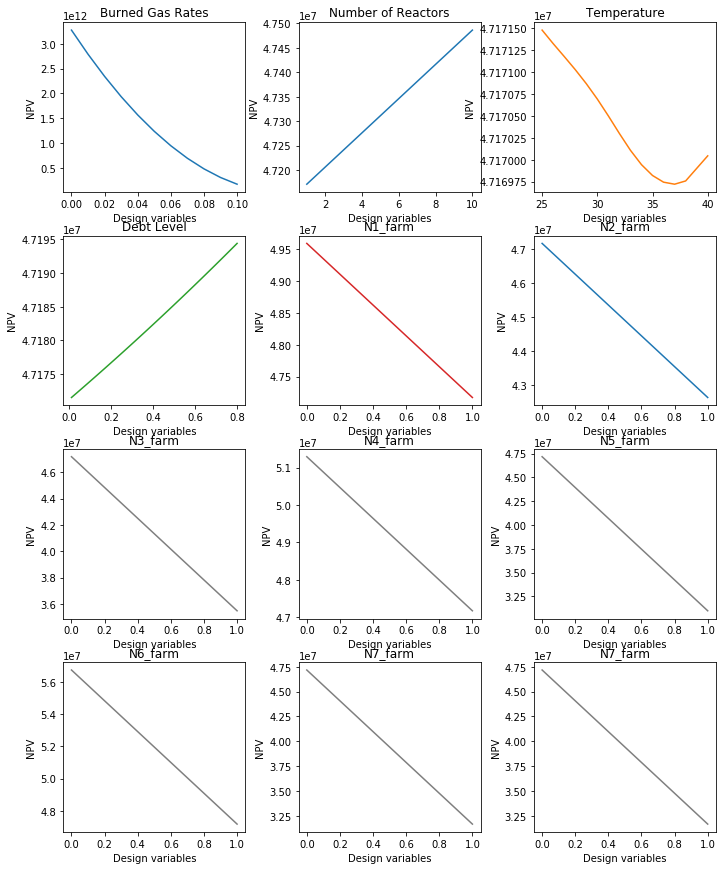

In [195]:
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from sko.GA import GA

from constants import *
from sensitivity_cost_module import do_all_list_cp,system_npv,JtokWh ,farmer_npv
from digesterModule import digester
import sensitivity_cost_module as C2
import Transport as T
import biogas as B
import pickle
from math import inf

# Variables we want to keep track in DOE
farm=[]
system=[]
# with open('data_transport.p', 'rb') as fp:
#     dict_T = pickle.load(fp)
with open('full_transp.p', 'rb') as fp:
    dict_T = pickle.load(fp)

import matplotlib.pyplot as plt
import autograd.numpy as np

vector = [4.83662871e-01, 1.00000000e+00, 2.62359775e+01, 
        1.11820675e-03, 1.00000000e+00, 0.00000000e+00,0.00000000e+00, 
        1.00000000e+00, 0.00000000e+00, 1.00000000e+00,0.00000000e+00]


def biodigestor(dv_n,dv_in,printt=False,pen=True):
    
    global vector
    
    ##DESIGN VARIABLES##

    V_grate = vector[0] #burned gas rate
    n_g = vector[1] #number of reactor
    Tdig = vector[2] #operating temperature
    debt_level = vector[3] #Portion of total capex required funded with debt
    active_farms = vector[4:11]
    
    #Switcher for DV change
    if dv_n==1: #Vgburn
        V_grate = dv_in
    elif dv_n==2: #generator
        n_g = dv_in
    elif dv_n==3: #temperature
        Tdig = dv_in
    elif dv_n==4: #debt
        debt_level = dv_in
    elif dv_n==5: #farm1
        active_farms[0] = dv_in
        # print('farm1',dv_in)
        # print(active_farms)
    elif dv_n==6: #farm2
        active_farms[1] = dv_in
        # print('farm2',dv_in)
        # print(active_farms)
    elif dv_n==7: #farm3
        active_farms[2] = dv_in
        # print('farm3',dv_in)
        # print(active_farms)
    elif dv_n==8: #farm4
        active_farms[3] = dv_in
        # print('farm4',dv_in)
        # print(active_farms)
    elif dv_n==9: #farm5
        active_farms[4] = dv_in
        # print('farm5',dv_in)
        # print(active_farms)
    elif dv_n==10: #farm6
        active_farms[5] = dv_in
        # print('farm6',dv_in)
        # print(active_farms)
    elif dv_n==11: #farm7
        active_farms[6] = dv_in
        # print('farm7',dv_in)
        # print(active_farms)
        
    

#     active_farms= vector[4:11] 
#     active_farms = [0 if num<1 else 1 for num in active_farms ]

    if printt:
        [distance, wIn, total_solids_perc, wComp] = T.load_data(*active_farms,printt)
    else:
        [distance, wIn, total_solids_perc, wComp] = dict_T[tuple(active_farms)]
    
    [W_a, typ, V_d, G_in, G_comp, digOut, digOut_comp] = digester(wIn,wComp,Tdig)
    # H_needed = JtokWh(H_needed*1000)
    # print('----')
    
    #biogas module
    V_g = B.biomethane(G_in, G_comp) #biomethane
    f_p = B.biofertilizer(digOut) 
    ghg_r, ghg_c = B.ghg(W_a, wComp, G_in, G_comp) #ghg_r: released gas, ghg_c: captured gas
    bgm_total = B.bgm_cost(G_comp, G_in, digOut)
    
    #COST Module
    V_g =V_g*working_days
    ghg = pd.DataFrame()
    ghg['ghg_lf']=ghg_r
    ghg['ghg_tech']=ghg_c
    ghg['gas']= ['CH4','CO2','NOX','SOX']
    list_ghg = []
    for gas in ['CH4','CO2','NOX','SOX']:
        list_ghg.append(ghg[ghg['gas']==gas].values.flatten().tolist())
    list_ghg = do_all_list_cp(W_a,distance,list_ghg)

    V_gburn = V_grate * V_g #burned gas

    return -farmer_npv(n_g,V_gburn,V_d,typ,distance,f_p,V_g,debt_level,e_c,e_priceB,f_used,p_bf,printt,pen)



## Sensitivity Analysis - DV Configuration
import numpy as np

print('based on:',vector)
print()


#burned gas rate
bgrs = np.linspace(0, 10,11)/100
returned_dv0 = []
for bgr in bgrs:
    returned_dv0.append(biodigestor(2,bgr))
print('returned NPV for the number of reactors',returned_dv0)

#number of reactor
ngs = np.linspace(1, 10,10)
returned_dv1 = []
for ng in ngs:
    returned_dv1.append(biodigestor(2,ng))
print('returned NPV for the number of reactors',returned_dv1)

#temperature
Tdigs = np.linspace(25, 40,15,dtype=int)
returned_dv2 = []
for dig in Tdigs:
    returned_dv2.append(biodigestor(3,dig))
print('returned NPV for temperature',returned_dv2)

#debt
debts = np.linspace(1,80,80,dtype=int)/100
returned_dv3 = []
for debt in debts:
    returned_dv3.append(biodigestor(4,debt))
print('returned NPV for debt',returned_dv3)

#farm1
farm1 = np.linspace(0,1,2,dtype=int)
returned_dv4 = []
for farm in farm1:
    returned_dv4.append(biodigestor(5,farm))
print('returned NPV for Farm1',returned_dv4)

#farm2
farm2 = np.linspace(0,1,2,dtype=int)
returned_dv5 = []
for farm in farm2:
    returned_dv5.append(biodigestor(6,farm))
print('returned NPV for Farm2',returned_dv5)

#farm3
farm3 = np.linspace(0,1,2,dtype=int)
returned_dv6 = []
for farm in farm1:
    returned_dv6.append(biodigestor(7,farm))
print('returned NPV for Farm3',returned_dv6)

#farm4
farm4 = np.linspace(0,1,2,dtype=int)
returned_dv7 = []
for farm in farm4:
    returned_dv7.append(biodigestor(8,farm))
print('returned NPV for Farm4',returned_dv6)

#farm5
farm5 = np.linspace(0,1,2,dtype=int)
returned_dv8 = []
for farm in farm5:
    returned_dv8.append(biodigestor(9,farm))
print('returned NPV for Farm5',returned_dv8)

#farm6
farm6 = np.linspace(0,1,2,dtype=int)
returned_dv9 = []
for farm in farm6:
    returned_dv9.append(biodigestor(10,farm))
print('returned NPV for Farm6',returned_dv9)

#farm7
farm7 = np.linspace(0,1,2,dtype=int)
returned_dv10 = []
for farm in farm7:
    returned_dv10.append(biodigestor(11,farm))
print('returned NPV for Farm7',returned_dv10)


#Plot graphs
fig, axs = plt.subplots(4, 3,figsize=(10,12))
axs[0, 0].plot(bgrs, returned_dv0)
axs[0, 0].set_title('Burned Gas Rates')
axs[0, 1].plot(ngs, returned_dv1)
axs[0, 1].set_title('Number of Reactors')
axs[0, 2].plot(Tdigs, returned_dv2, 'tab:orange')
axs[0, 2].set_title('Temperature')
axs[1, 0].plot(debts, returned_dv3, 'tab:green')
axs[1, 0].set_title('Debt Level')
axs[1, 1].plot(farm1, returned_dv4, 'tab:red')
axs[1, 1].set_title('N1_farm')
axs[1, 2].plot(farm2, returned_dv5, 'tab:blue')
axs[1, 2].set_title('N2_farm')
axs[2, 0].plot(farm3, returned_dv6, 'tab:grey')
axs[2, 0].set_title('N3_farm')
axs[2, 1].plot(farm4, returned_dv7, 'tab:grey')
axs[2, 1].set_title('N4_farm')
axs[2, 2].plot(farm5, returned_dv8, 'tab:grey')
axs[2, 2].set_title('N5_farm')
axs[3, 0].plot(farm6, returned_dv9, 'tab:grey')
axs[3, 0].set_title('N6_farm')
axs[3, 1].plot(farm7, returned_dv10, 'tab:grey')
axs[3, 1].set_title('N7_farm')
axs[3, 2].plot(farm7, returned_dv10, 'tab:grey')
axs[3, 2].set_title('N7_farm')
fig.tight_layout()

for ax in axs.flat:
    ax.set(xlabel='Design variables', ylabel='NPV')

#tornado graph (based on the change of design variables)
#parameters
#digester: volume of reactor ()

gradient [-2.27627252e+02 -2.65211556e+02 -3.17619258e+02 -2.97049627e+02
 -2.23134503e+02 -1.69247692e+02 -1.50335606e+02 -1.48340499e+02
 -2.42785866e+02  1.30942048e+02  1.77903281e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04 -1.39932373e+05
 -1.39932373e+05  3.49830932e+04  3.49830932e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04  3.49830932e+04
  3.49830932e+04 -1.39932373e+05 -1.39932373e+05  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04 -1.39183465e+05
 -1.56788826e+05 -2.65211556e+02 -3.17619258e+02 -2.97049627e+02
 -2.23134503e+02 -1.69247692e+02 -1.50335606e+02 -1.48340499e+02
 -2.42785866e+02  1.30942048e+02  1.77903281e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04  3.49830932e+04
  3.49830932e+04  3.49830932e+04  3.49830932e+04 -1.39183465e+05
 -1.56788826e+05

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

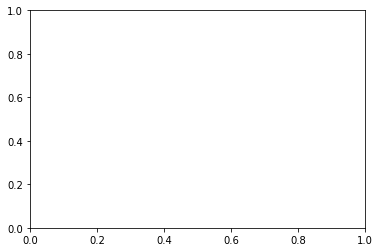

In [181]:
## GRADIENT
from autograd import grad  
grad_bio = grad(biodigestor)

#grad_bio(2, ngs)


print('gradient',np.gradient(np.array(returned_v, dtype=float), axis=0))


#number of reactor
ngs = np.linspace(1, 10,10)
returned_dv1 = []
for ng in ngs:
    returned_dv1.append(biodigestor(2,ng))
print('returned NPV for the number of reactors',returned_dv1)

#grad = np.gradient(np.gradient(np.array( returned_dv1, dtype=float), axis=0))

from autograd import jacobian



from autograd import jacobian

dAdk1 = jacobian(biodigestor,1)
dAdk_1 = jacobian(biodigestor, 2)

plt.plot(ngs, np.abs(dAdk1(2,ngs)))
plt.plot(ngs, np.abs(dAdk_1(2,ngs)))
plt.xlim([0, 0.5])
plt.ylim([0, 0.1])
plt.xlabel('t')
plt.legend(['$S_{k1}$', '$S_{k\_1}$'])


* Point out the design variables in the code
* confirm x* and function output
* which parameters to test with?
* All the codes are finalized? Which one I can use?
* If grad is not working, any possible workaround? e.g. gradienting the results?